# Reading BCI_C_IV dataset

Imports

In [1]:
import pandas as pd
import numpy as np
import os
import mne
from math import ceil

Data preprocessing

In [2]:
rootdir = '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut'

MAX_LEN = 1875
patients_tuple = tuple(range(1, 10))
classes_tuple = ("left", "right")
classes = {"left": 0, "right": 1}

# for "BCI_C_IV" channel names are correctly_determined.

# For Inno dataset - I'm not sure

channel_names = ['EEG-Fz', 'EEG', 'EEG', 'EEG', 'EEG', 'EEG', 'EEG', 'EEG-C3', 'EEG',
                 'EEG-Cz', 'EEG', 'EEG-C4', 'EEG', 'EEG', 'EEG', 'EEG', 'EEG',
                 'EEG', 'EEG', 'EEG-Pz', 'EEG', 'EEG', 'EOG-left', 'EOG-central', 'EOG-right']
sampling_freq = 250
start = 2 * sampling_freq
end = int(6.5 * sampling_freq)
input_dim = 25

l_freq = 7
h_freq = 30
l_trans_bandwidth = 0.5
h_trans_bandwidth = 0.5

In [3]:
# Helper classes

class CV_iteration():
    def __init__(self, name: str, train_set: list, valid_set: list, test_set: list):
        self.name = name
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set

In [4]:
# helper functions

def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros


def fix_df(df: pd.DataFrame, zero_list_function, dataset: str, MAX_LEN: int,
           channel_names: list, use_only: str, start: int, end: int,
           l_freq: float, h_freq: float, l_trans_bandwidth: float,
           h_trans_bandwidth: float):

    df = df.drop(['Unnamed: 0'], axis=1)
    if dataset == "Inno":
        numb_of_channels = 32
        sfreq = 1000
        main_channels = ['C3', 'Cz', 'C4']
    elif dataset == "BCI_C_IV":
        numb_of_channels = 25
        sfreq = 250
        main_channels = ['EEG-C3', 'EEG-Cz', 'EEG-C4']

    df.columns = list(range(numb_of_channels))
    # ADD EXTRA ROWS HERE
    foundation = [zero_list_function(numb_of_channels)
                  for i in range(MAX_LEN - len(df))]
    foundation = pd.DataFrame(foundation)
    df = pd.concat([df, foundation], ignore_index=True, axis=0)

    channel_types = ['eeg']*numb_of_channels
    ch_indices = [i for i, ch_name in enumerate(
        channel_names) if ch_name in main_channels]

    channel_names = [channel_names[i] for i in ch_indices]
    channel_types = [channel_types[i] for i in ch_indices]

    if use_only == 'C':
        # Drop some channels - 3
        np_eeg = df.iloc[:, ch_indices].to_numpy().T
    else:
        # Keep all channels - 32 or 25
        np_eeg = df.to_numpy().T

    # # Baseline correction
    # if dataset == "Inno":
    #     times = np.linspace(0, 10.094, 10095)
    #     np_eeg = mne.baseline.rescale(
    #         np_eeg, times, (0., 5.0), mode='mean', copy=False, verbose=False)

    # Let's just apply default FIR filtering
    np_eeg = mne.filter.filter_data(np_eeg, sfreq=sfreq, l_freq=l_freq, h_freq=h_freq,
                                    l_trans_bandwidth=l_trans_bandwidth, h_trans_bandwidth=h_trans_bandwidth,
                                    copy=False, verbose=False)

    df = pd.DataFrame(np_eeg.T)
    # Only select desired range
    df = df[start:end]

    # # Apply scaling
    # scaler = RobustScaler()
    # df = scaler.fit_transform(df)

    # Add generation of Spectrograms

    return df

In [5]:
# Helper functions

def form_data_tree(rootdir: str, classes_tuple: tuple, patients_tuple: tuple):
    # This is the main object with data
    classes_data = {}                       # Dict with lists

    for dirs, subdirs, files in os.walk(rootdir):
        key = dirs.split('/')[-1]
        if key in classes_tuple:
            patients_dict = {}
            for i in patients_tuple:
                patients_dict[i] = []
            classes_data[key] = patients_dict
            for file in files:
                patient_number = int(file.split('_')[0])
                data_link = os.path.join(dirs, file)
                classes_data[key][patient_number].append(data_link)
    return classes_data

def custom_CV(folder_tree: dict, files_in_a_tree: int):

    number_of_folds = 4
    elements_per_list = files_in_a_tree/(9*2)
    part = ceil(elements_per_list/number_of_folds)
    print(part)
    fold_1, fold_2, fold_3, fold_4 = [], [], [], []

    # Classes_data - original Dataset:
    # It consists of 8*20 list of len = 25

    for i in folder_tree.values():
        for k, j in i.items():
            for filename in j[:part]:
                fold_1.append(filename)
            for filename in j[part: 2 * part]:
                fold_2.append(filename)
            for filename in j[2 * part: 3 * part]:
                fold_3.append(filename)
            for filename in j[3 * part:]:
                fold_4.append(filename)

    return (fold_1, fold_2, fold_3, fold_4)

In [6]:
# Helper functions

def evaluate_iteration(iteration: CV_iteration, patients_tuple: tuple):
    def check_distribution(part_of_dataset):
        patients_dict = {}
        for i in patients_tuple:
            patients_dict[i] = 0

        for i in patients_dict:
            for j in part_of_dataset:
                # Getting the patient №
                if int(j.split('/')[-1].split('_')[0]) == i:
                    patients_dict[i] = patients_dict[i] + 1
        return patients_dict
    print(f'''Distribution of patients among train set of {iteration.name} is \n {check_distribution(iteration.train_set)} \n
              Distribution of patients among valid set of {iteration.name} is \n {check_distribution(iteration.valid_set)} \n
              Distribution of patients among test set of {iteration.name} is \n {check_distribution(iteration.test_set)} \n ''')

In [7]:
classes_data = form_data_tree(rootdir, classes_tuple, patients_tuple)
files_in_a_tree = 1298

folds_slice = custom_CV(classes_data, files_in_a_tree)

iteration = CV_iteration('original', train_set=folds_slice[0]+folds_slice[1] +
                         folds_slice[2], 
                            valid_set=folds_slice[3], test_set=folds_slice[3])

evaluate_iteration(iteration, patients_tuple)

19
Distribution of patients among train set of original is 
 {1: 114, 2: 114, 3: 114, 4: 114, 5: 114, 6: 114, 7: 114, 8: 114, 9: 114} 

              Distribution of patients among valid set of original is 
 {1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30, 8: 30, 9: 30} 

              Distribution of patients among test set of original is 
 {1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30, 8: 30, 9: 30} 
 


In [8]:
print(len(folds_slice[0]))
print(len(folds_slice[1]))
print(len(folds_slice[2]))
print(len(folds_slice[3]))

342
342
342
270


Example of Spectrogram Generation

In [9]:
example_path = iteration.train_set[8]
example = pd.read_csv(example_path)

In [10]:
example = fix_df(example, zerolistmaker, 'BCI_C_IV', MAX_LEN, channel_names,
                'C', start, end, l_freq, h_freq, l_trans_bandwidth, h_trans_bandwidth)

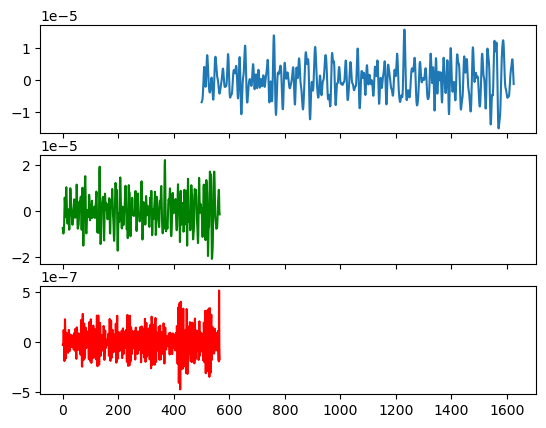

In [11]:
# python wavelet transfrom
import pywt
import matplotlib.pyplot as plt

cA, cD = pywt.dwt(example[0], 'db4')    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(example[0])
ax2.plot(cA,'-g')
ax3.plot(cD,'-r')


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
Class of continuous wavelet functions：
['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


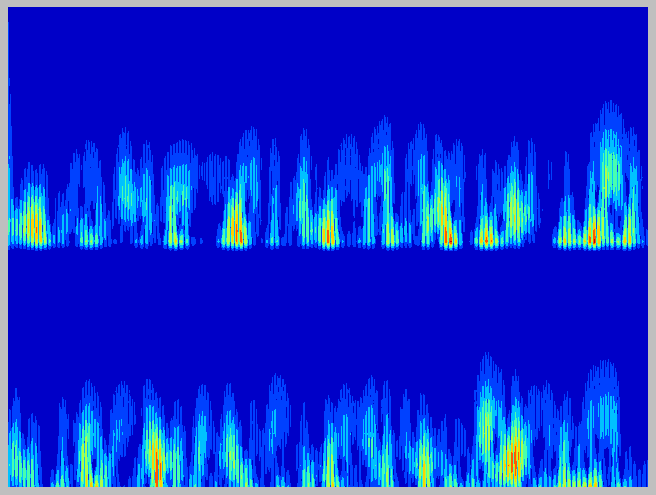

In [12]:
# Wavelet transform generates time-frequency graph

print(plt.style.available)
plt.style.use('classic')
wavlist = pywt.wavelist(kind='continuous')
print("Class of continuous wavelet functions：")
print(wavlist)
t = np.arange(2,6.5,1.0/sampling_freq)
wavename = 'morl'    # "cmorB-C" where B is the bandwidth and C is the center frequency.
# frequencies = pywt.scale2frequency('cmor1.5-0.5', [1, 2, 3, 4]) / (1/sampling_rate)
# print(frequencies)
totalscal = 64    # scale 
fc = pywt.central_frequency(wavename) #  central frequency
cparam = 2 * fc * totalscal
scales = cparam/np.arange(1,totalscal+1)
# C3 channel


# [cwtmatr, frequencies] = pywt.cwt(example[0],scales,wavename,1.0/sampling_freq) # continuous wavelet transform
# fig = plt.figure(1)
# plt.contourf(t, frequencies, abs(cwtmatr))
# plt.ylabel(u"freq(Hz)")
# plt.xlabel(u"time(s)")
# plt.colorbar()
# fig.savefig('C3.png')
# fig = plt.figure(2)
# # C4 channel
# [cwtmatr, frequencies] = pywt.cwt(example[2],scales,wavename,1.0/sampling_freq) #连续小波变换
# plt.contourf(t, frequencies, abs(cwtmatr))
# plt.ylabel(u"freq(Hz)")
# plt.xlabel(u"time(s)")
# plt.colorbar()
# fig.savefig('C4.png')

[cwtmatr3, frequencies3] = pywt.cwt(example[0],scales,wavename,1.0/sampling_freq) 
[cwtmatr4, frequencies4] = pywt.cwt(example[2],scales,wavename,1.0/sampling_freq) 

cwtmatr = np.concatenate([abs(cwtmatr3[7:30,:]), abs(cwtmatr4[7:30,:])],axis=0)   # the sequence is C3 then C4
fig = plt.figure()
plt.contourf(cwtmatr)
plt.xticks([])  # remove x
plt.yticks([])  # remove y
plt.axis('off') # remove axis
fig.set_size_inches(800/100.0,600/100.0)#  set pixels width*height
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0) 
plt.margins(0,0)
fig.savefig('fig.png')



In [13]:
example_path.split('/')[-2]



'left'

In [14]:
frequencies3.shape

(64,)

In [15]:
example_path.split('/')[-1].split('.')[0]

'1_11'

# Making images from all files

Train data

In [ ]:
for i in iteration.train_set:
    print(i)
    data = pd.read_csv(i)
    data = fix_df(data, zerolistmaker, 'BCI_C_IV', MAX_LEN, channel_names,
                'C', start, end, l_freq, h_freq, l_trans_bandwidth, h_trans_bandwidth)
    [cwtmatr3, frequencies3] = pywt.cwt(data[0],scales,wavename,1.0/sampling_freq) 
    [cwtmatr4, frequencies4] = pywt.cwt(data[2],scales,wavename,1.0/sampling_freq) 
    cwtmatr = np.concatenate([abs(cwtmatr3[7:30,:]), abs(cwtmatr4[7:30,:])],axis=0)   # the sequence is C3 then C4
    fig = plt.figure()
    plt.contourf(cwtmatr)
    plt.xticks([])  # remove x
    plt.yticks([])  # remove y
    plt.axis('off') # remove axis
    fig.set_size_inches(800/100.0,600/100.0)#  set pixels width*height
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0) 
    plt.margins(0,0)
    if i.split('/')[-2] == "right":
        filepath = f"images_train/right/{i.split('/')[-1].split('.')[0]}.png"
    elif i.split('/')[-2] == "left":
        filepath = f"images_train/left/{i.split('/')[-1].split('.')[0]}.png"
    fig.savefig(filepath)
    fig.clear()

Test data

In [19]:
iteration.test_set

['/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_98.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_25.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_65.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_31.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_19.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_6.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_103.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_14.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_1.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_140.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_10.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_90.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_129.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_78.csv',
 '/mnt/nikita_disk/Neuroscience/BCI_C_IV/Train_cut/left/1_71.

In [ ]:
for i in iteration.test_set:
    data = pd.read_csv(i)
    data = fix_df(data, zerolistmaker, 'BCI_C_IV', MAX_LEN, channel_names,
                'C', start, end, l_freq, h_freq, l_trans_bandwidth, h_trans_bandwidth)
    [cwtmatr3, frequencies3] = pywt.cwt(data[0],scales,wavename,1.0/sampling_freq) 
    [cwtmatr4, frequencies4] = pywt.cwt(data[2],scales,wavename,1.0/sampling_freq) 
    cwtmatr = np.concatenate([abs(cwtmatr3[7:30,:]), abs(cwtmatr4[7:30,:])],axis=0)   # the sequence is C3 then C4
    fig = plt.figure()
    plt.contourf(cwtmatr)
    plt.xticks([])  # remove x
    plt.yticks([])  # remove y
    plt.axis('off') # remove axis
    fig.set_size_inches(800/100.0,600/100.0)#  set pixels width*height
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace =0, wspace =0) 
    plt.margins(0,0)
    if i.split('/')[-2] == "right":
        filepath = f"images_test/right/{i.split('/')[-1].split('.')[0]}.png"
    elif i.split('/')[-2] == "left":
        filepath = f"images_test/left/{i.split('/')[-1].split('.')[0]}.png"
    fig.savefig(filepath)
    fig.clear()